In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import georaster as gr

In [2]:
sns.set_theme()

## Load data

In [3]:
data = pd.read_csv('data/starships_clean.csv', index_col='id')

In [4]:
# Cast again date
data['stream_date'] = pd.to_datetime(data['stream_date'])

In [5]:
# Rename column
data.rename(columns={'level2': 'ship_type'}, inplace=True)
data.rename(columns={'stream_date': 'date'}, inplace=True)

## Explore properties

In [6]:
data

,ship_type,date,lon,lat
id,,,,
1,TIE Fighter,2018-05-07 12:00:00,-19.950145,27.552059
2,TIE bomber,2018-05-07 12:00:00,-19.925915,27.527897
3,TIE bomber,2018-05-07 12:00:00,-19.927374,27.527464
4,TIE Fighter,2018-05-07 12:00:00,-19.915460,27.516342
5,TIE Fighter,2018-05-07 12:00:00,-19.948334,27.557954
...,...,...,...,...
3459,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.916284,27.515434
2524742,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.949415,27.550263
2524752,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.948473,27.550805


### Inspect id

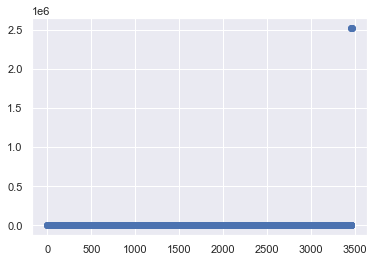

In [7]:
# Is id continuous?
plt.scatter(range(len(data.index)), data.index)

- There seems to have an outlier in the end of the series
- Id seems continuous (without the outlier)

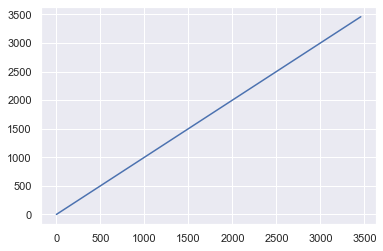

In [8]:
# (temprorarilly) Remove the outliers to zoom on the remaining ids
plt.plot(range(len(data.index[:-4])), data.index[:-4])

Analysis:
- Ids indeed seem continuous

Questions:
- Is there a meaning in the id? -> **YES**
- Is the id correlated with:
    - the type of starship?
    - the time (linear) -> **YES** (see eda_cleaning)
    - the year period (cyclical)

### Inspect stream_date

Text(0.5, 1.0, 'Complete date')

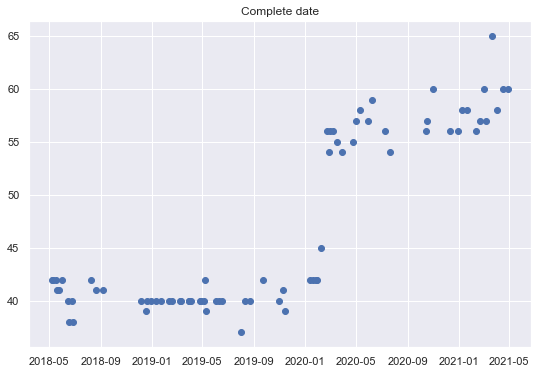

In [9]:
plt.figure(figsize=(9, 6))
date_counts = data['date'].value_counts()
plt.scatter(date_counts.index, date_counts.values)
plt.title('Complete date')

Analysis:
- There is a clear event at ±2020-02, with + half ships
- before 2020-02: number of ships within 38-42
- after 2020-02: number of ships within 54-60
- Seems like an outlier with 65 ships in ±2021-03

Questions:
- Was there a diminution / rupture of a certain type of ship before the event?
- What is the repartition of new ships?
    - if it is a general augmentation (for all types), it shouldn't be a diminution of one type of ship only
    - was it a progressive or a brutal diminution of ships?

#### Test hyp: more data points during estival period, fewer during winter (because ships are hidden in their boxes)

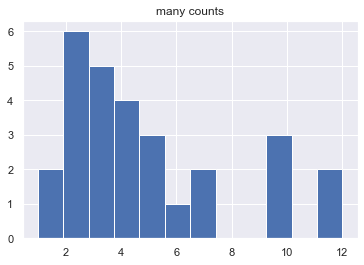

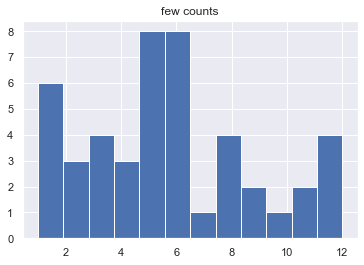

In [10]:
COUNT_LIMIT = 50

counts_by_date = data.groupby('date').count()
ma_many_ships = counts_by_date['ship_type'] > COUNT_LIMIT
months_many = counts_by_date[ma_many_ships].index.month
plt.hist(months_many, bins=12)
plt.title('many counts')
plt.show()

ma_few_ships = counts_by_date['ship_type'] < COUNT_LIMIT
months_few = counts_by_date[ma_few_ships].index.month
plt.hist(months_few, bins=12)
plt.title('few counts')
plt.show()

- There is no clear pattern. It is not correlated with specific months as expected

#### Test hyp: many data points during the week, fewer during week-end (because ships are hidden in their boxes)

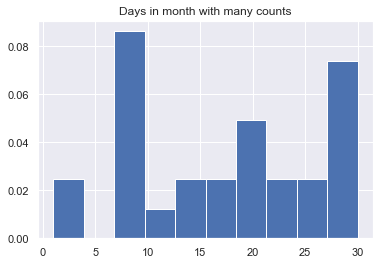

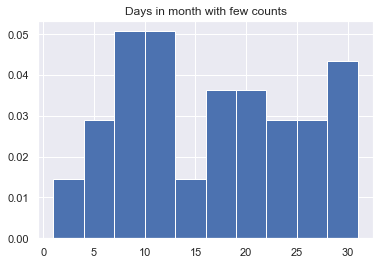

In [11]:
COUNT_LIMIT = 50

day_many = counts_by_date[ma_many_ships].index.day
plt.hist(day_many, density=True)
plt.title('Days in month with many counts')
plt.show()

day_few = counts_by_date[ma_few_ships].index.day
plt.hist(day_few, density=True)
plt.title('Days in month with few counts')
plt.show()

- There seems to have a slight increase around 10, 20 and 30
- SImilarily, there seems to have a slight decrease around 1 and 15
- These should be tested for their significance (might be random noise)

In [12]:
print(day_many)
print(day_few)

Int64Index([22, 25, 28,  7, 15, 27, 22,  1,  9, 30,  7,  9, 21, 13, 16, 30,  9,
            29,  7, 19, 10, 20, 28,  7, 20,  2, 16, 28],
           dtype='int64', name='date')
Int64Index([ 7, 11, 16, 19, 24,  1, 15, 18, 23, 26,  9, 20,  7,  6, 17, 19, 30,
            10, 21,  9, 17,  8, 11, 29, 30,  4, 25, 27,  4,  8, 10,  3, 10, 16,
            31, 10, 23, 22, 30,  8, 14, 11, 19, 26, 29,  6],
           dtype='int64', name='date')


### Investigate ship_type

#### Ship_type repartition

TIE Fighter              2034
Imperial SpaceShuttle     827
TIE bomber                511
Civilian Star Shuttle      89
Surveillance droid          2
Name: ship_type, dtype: int64


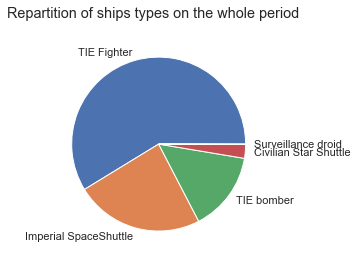

In [13]:
# Total period
ship_type_total = data['ship_type'].value_counts()
ship_type_total.plot.pie(label="")
plt.suptitle('Repartition of ships types on the whole period')
print(ship_type_total)

In [14]:
# Get extreme dates
date_first = data['date'].min()
date_last = data['date'].max()

# Masks
ma_snap_first = data['date'] == date_first
ma_snap_last = data['date'] == date_last

# Extract ship_type for the given dates
ship_type_first = data[ma_snap_first]['ship_type'].value_counts()
ship_type_last = data[ma_snap_last]['ship_type'].value_counts()

TIE Fighter              23
Imperial SpaceShuttle    11
TIE bomber                7
Civilian Star Shuttle     1
Name: ship_type, dtype: int64


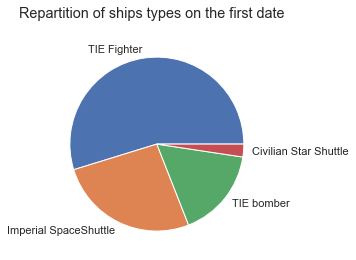

In [15]:
ship_type_first.plot.pie(label="")
plt.suptitle('Repartition of ships types on the first date')
print(ship_type_first)

TIE Fighter              38
Imperial SpaceShuttle    13
TIE bomber                7
Civilian Star Shuttle     2
Name: ship_type, dtype: int64


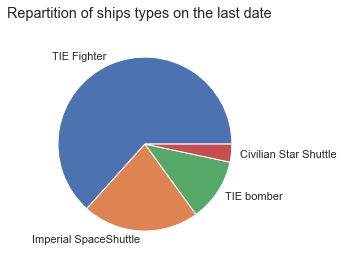

In [16]:
ship_type_last.plot.pie(label="")
plt.suptitle('Repartition of ships types on the last date')
print(ship_type_last)

#### Evolution of each ship_type

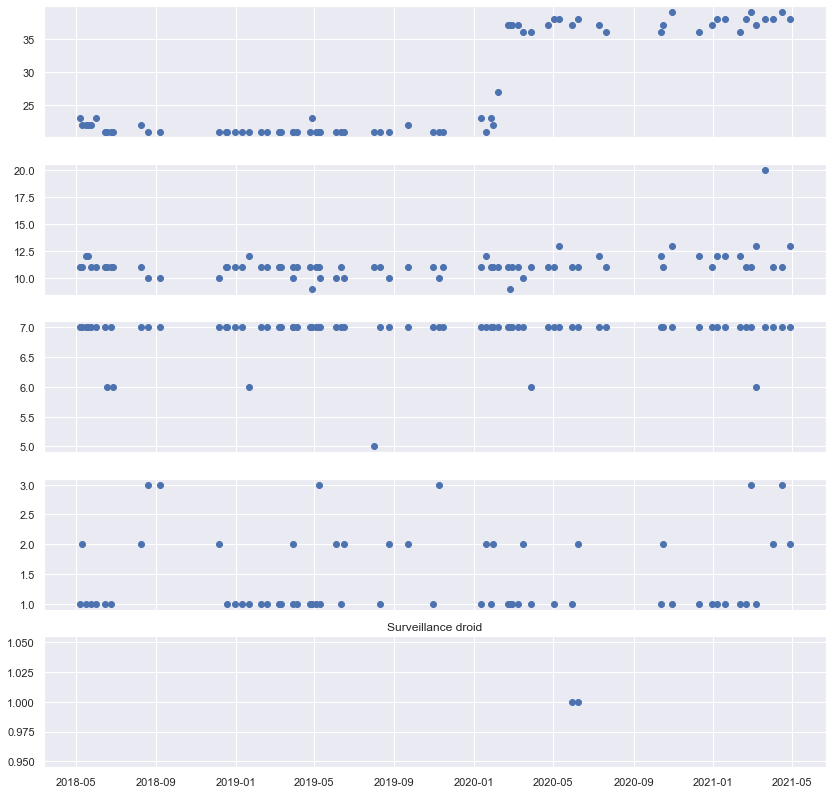

In [17]:
# Get the count of a ship_type for each date
fig, axs = plt.subplots(5, 1, figsize=(14, 14), sharex=True)
for i, ship_type in enumerate(data['ship_type'].value_counts().index):
    ma_ship_type = data['ship_type'] == ship_type
    evol_count = data[ma_ship_type].groupby('date').count()['ship_type']
    axs[i].scatter(evol_count.index, evol_count)
    plt.title(ship_type)

#### We suspect some vehicles might have been decommissioned and remain static. Could this information be confirmed by the detections ?
-> **YES**: each type of ship has a fluctuating count that could be explained by **decommissioned** ships on a more or less frequent basis

- Surveillance droid:
    - only 2 points, could be due to:
        - noise: the CV detection algorithm made a mistake
        - hidden: since its a droid, it is never left outside so it is improbable to detect it? (only by chance)
    - otherwise constant over time


- Civilian star shuttle:
    - 3 modes [1, 2, 3] might be due to:
        - noise
        - some might be **decommissioned**: there seems to have a periodic pattern
    - Most often 1:
        - The remaining might often be hidden
    - otherwise constant over time


- TIE Bomber:
    - 3 modes [5, 6, 7]
    - Very often 7
    - 6 on a cyclical basis, might be **decommissionned** sometimes
    - otherwise constant over time


- Imperial SpaceShuttle:
    - very slight increase over time:
        - [10-12] before 2020-02
        - [11-13] after
    - might be a cyclical pattern going down and up again:
        - might be pure noise
        - might be solid, potentially because of **decommissionned** ships
    - Clear outlier when at 20 (once)


- TIE Fighter:
    - hugh increase over time:
        - [20-23] before event
        - [36-39] after event
        - has seen the highest increase (and single very significative)
        - the variations might be due to:
            - pure noise
            - potential **decommissionned** of ships

#### Is there any meaningful trend or rare events that could help understand the evolution of this installation ? How would you develop an automatic alerting system to detect such anomalies ?
-> **YES**: there is a huge brutal augmentation of TIE Fighters count in ±2020-03.

#### Other
- There are no observations within [2018-09-2018-12] and [2020-08-2020-12] for all the ship_types (due to winter?)

## Explore positions
- Are there any re-organization of the space? e.g. ship_type moved to another place?

### High activity areas (presence)

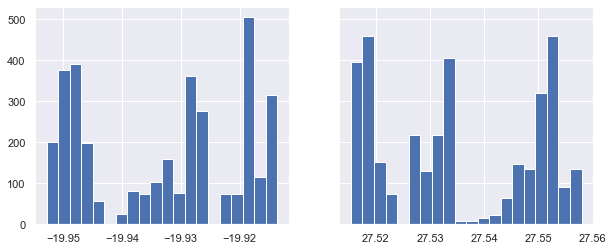

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
counts_lon, bins_lon, _ = axs[0].hist(data['lon'], bins=20)
counts_lat, bins_lat, _ = axs[1].hist(data['lat'], bins=20)
plt.show()

- There seem to have 3 favored places
    - in the *longitude* axis, around:
        - -19.95
        - -19.928
        - -19.918
    - in the *latitude* axis, which might be parking garages, around:
        - 27.52
        - 27.532
        - 27.55

In [19]:
N_CENTROIDS = 4  # 4 because there are a lot of them in a same place (see left)

modes_lon = pd.DataFrame({'counts':counts_lon, 'bins':bins_lon[:-1]})
modes_lat = pd.DataFrame({'counts':counts_lat, 'bins':bins_lat[:-1]})

x_centroids = modes_lon.sort_values('counts', ascending=False)[:N_CENTROIDS]['bins'].values
y_centroids = modes_lat.sort_values('counts', ascending=False)[:N_CENTROIDS]['bins'].values

Construct the background image

In [21]:
raster_name = 'data/space_port_image.tif'
raster = gr.MultiBandRaster(raster_name)

# Boundaries
x_min, x_max, y_min, y_max = raster.extent
raster.extent

(-20.0, -19.8627102, 27.4990877, 27.5701161)

In [22]:
# Average all 3 background image layers
img_arr = raster.r.mean(axis=2)

Construct ship type color correspondance table

In [23]:
ship_types = data['ship_type'].unique()
ship_types.sort()

In [24]:
# Construct color scale
color_scale = ['#7A5E1B', '#229954', '#F4D03F', '#193F7D', '#C0392B']
# Construct color-ship correspondance table
ship_color_table = {ship:color for (ship, color) in zip(ship_types, color_scale)}

Draw the plot

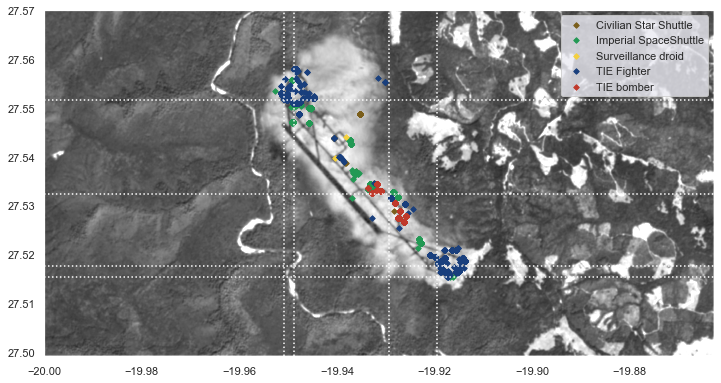

In [25]:
plt.figure(figsize=(12, 12))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

for ship, color in ship_color_table.items():
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=15, marker='D', label=ship)

# Add specific positions
for x in x_centroids:
    plt.vlines(x, y_min, y_max, colors='w', linestyles='dotted')
for y in y_centroids:
    plt.hlines(y, x_min, x_max, colors='w', linestyles='dotted')

plt.legend()
plt.show()

### Area by ship_type

#### Find centroids using mean and low std

In [26]:
stats_by_ship_type = data.groupby('ship_type').describe()

In [27]:
ma_centroid_lon = stats_by_ship_type['lon']['std'] < 0.01
ma_centroid_lon

ship_type
Civilian Star Shuttle     True
Imperial SpaceShuttle    False
Surveillance droid        True
TIE Fighter              False
TIE bomber                True
Name: std, dtype: bool

In [28]:
ma_centroid_lat = stats_by_ship_type['lat']['std'] < .005
ma_centroid_lat

ship_type
Civilian Star Shuttle    False
Imperial SpaceShuttle    False
Surveillance droid        True
TIE Fighter              False
TIE bomber                True
Name: std, dtype: bool

In [29]:
ma_centroid = stats_by_ship_type[ma_centroid_lon & ma_centroid_lat]
ma_centroid

lon                                             \
                    count       mean       std        min        25%   
ship_type                                                              
Surveillance droid    2.0 -19.939287  0.001711 -19.940496 -19.939891   
TIE bomber          511.0 -19.928480  0.002355 -19.933584 -19.930976   

                                                       lat             \
                          50%        75%        max  count       mean   
ship_type                                                               
Surveillance droid -19.939287 -19.938682 -19.938077    2.0  27.541833   
TIE bomber         -19.927387 -19.926192 -19.925898  511.0  27.529950   

                                                                          \
                         std        min        25%        50%        75%   
ship_type                                                                  
Surveillance droid  0.003053  27.539675  27.540754  27.541833  27.542913   
TIE bomber          0.002723  27.526576  27.527471  27.528809  27.532923   

                               
                          max  
ship_type                      
Surveillance droid  27.543992  
TIE bomber          27.534439

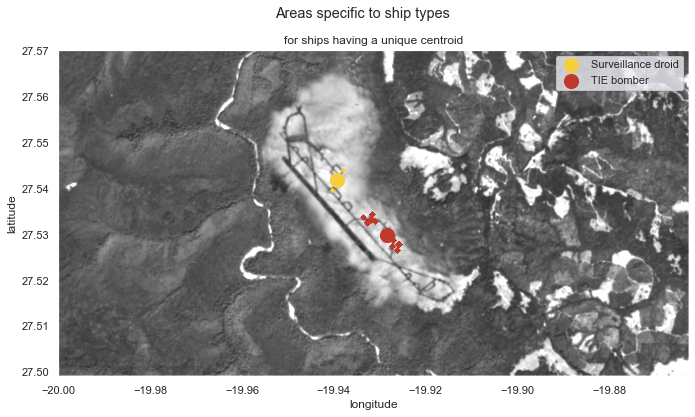

In [30]:
plt.figure(figsize=(12, 6))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

# Add ships centroids positions (corresponding to mean with low std)
for ship in ma_centroid.index:
    # Centroid
    x = ma_centroid['lon']['mean'].loc[ship]
    y = ma_centroid['lat']['mean'].loc[ship]
    color = ship_color_table[ship]
    plt.scatter([x], [y], label=ship, s=200, c=color)

    # Corresponding ships positions
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=10, marker='D')


plt.suptitle('Areas specific to ship types')
plt.title('for ships having a unique centroid')
plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

#### Centroids for all the ships positions

In [31]:
def recalculate_clusters(X, centroids, k):
    """ Recalculates the clusters """
    # Initiate empty clusters
    clusters = {}
    # Set the range for value of k (number of centroids)
    for i in range(k):
        clusters[i] = []
    for x in X.values:
        euc_dist = []
        for j in range(k):
            euc_dist.append(np.linalg.norm(x - centroids[j]))
        # Append the cluster of x to the dictionary
        clusters[euc_dist.index(min(euc_dist))].append(x)
    return clusters

def recalculate_centroids(centroids, clusters, k):
    """ Recalculates the centroid position based on the plot """
    for i in range(k):
        centroids[i] = np.average(clusters[i], axis=0)
    return centroids

In [32]:
# Init centroids
X = data[['lon', 'lat']]

K = 2
clusters2 = {}
for i in range(K):
    clusters2[i] = []

centroids2 = {}
for i in range(K):
    centroids2[i] = X.iloc[i]

clusters2 = recalculate_clusters(X=X, centroids=centroids2, k=K)
centroids2 = recalculate_centroids(centroids=centroids2, clusters=clusters2, k=K)

In [33]:
# Iterate multiple times to make centroids converge
for i in range(2):
    clusters2 = recalculate_clusters(X=X, centroids=centroids2, k=K)
    centroids2 = recalculate_centroids(centroids=centroids2, clusters=clusters2, k=K)

centroids2

{0: array([-19.94704827,  27.55104366]),
 1: array([-19.92310965,  27.52448261])}

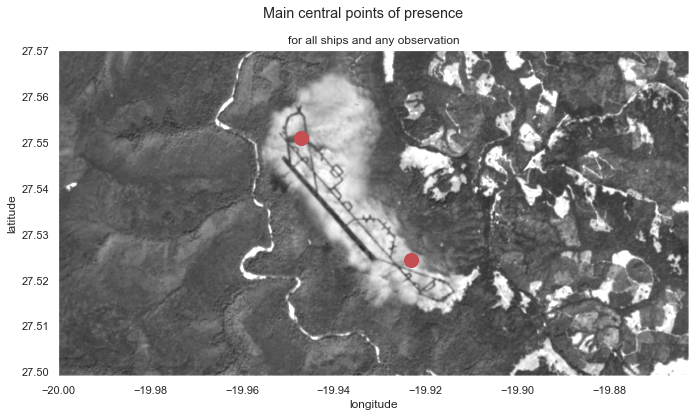

In [41]:
plt.figure(figsize=(12, 6))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

# Add ships centroids positions (computed using kmeans)
for i in centroids2:
    plt.scatter(centroids2[i][0], centroids2[i][1], c='r', s=200)

plt.suptitle('Main central points of presence')
plt.title('for all ships and any observation')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

#### Find ships having 2 centroids using kmeans

In [35]:
def kmeans(X, k, ship=None, n_iter=10):
    """ Compute centroids using kmeans algorithm """
    ma_ship = X['ship_type'] == ship
    X = X[ma_ship]
    X = X[['lon', 'lat']]

    clusters = {}
    for i in range(k):
        clusters[i] = []

    centroids = {}
    for i in range(k):
        centroids[i] = X.iloc[i]

    for i in range(n_iter):
        clusters = recalculate_clusters(X=X, centroids=centroids, k=k)
        centroids = recalculate_centroids(centroids=centroids, clusters=clusters, k=k)

    return centroids

In [36]:
centroids = {} 
# ship = 'Surveillance droid'
X = data.copy()
for ship in ship_types:
    centroids[ship] = kmeans(X=X, k=2, ship=ship)

In [37]:
# Keep only centroids that are enough spread on the map
spread_ships = []

for ship in ship_types:
    std = np.std(list(centroids[ship].values()), axis=0)
    mean_std = np.mean(std)
    if mean_std > .003:
        print(mean_std)
        spread_ships.append(ship)

0.008072902397262105
0.009269054687198519
0.015571843801279961


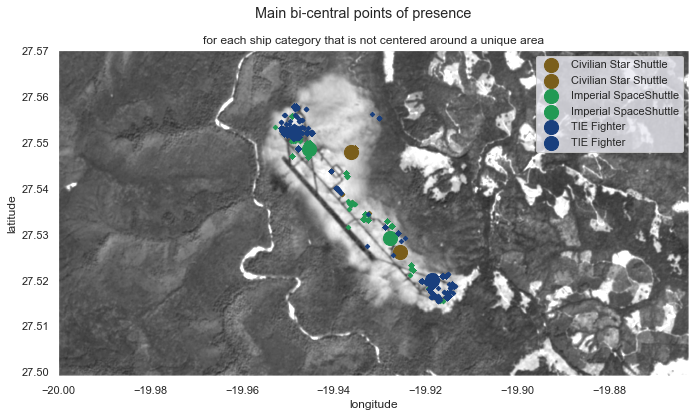

In [43]:
plt.figure(figsize=(12, 6))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

# Add ships centroids positions (computed using kmeans)
for ship in spread_ships:
    color = ship_color_table[ship]
    for i in centroids[ship]:
        plt.scatter(centroids[ship][i][0], centroids[ship][i][1], c=color, s=200, label=ship)

    # Corresponding ships positions
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=10, marker='D')

plt.suptitle('Main bi-central points of presence')
plt.title('for each ship category that is not centered around a unique area')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()

plt.show()

- Improve by displaying centroids only for ships that need 2 centroids (i.e. not the green)